## Chess Outcome Prediction
The goal is to build a machine learnign model to predict chess game outcomes based on FIDE ratings and tournament data. The Problem statement is a regression problem where we aim to predict the probability of win/draw/loss based on player ratings and other features.

In [ ]:
# !pip3 install shap

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached numba-0.58.1-cp38-cp38-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.7 kB)
  Using cached llvmlite-0.41.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.6/538.6 kB 4.6 MB/s eta 0:00:00
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached numba-0.58.1-cp38-cp38-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.7 MB)
Using cached llvmlite-0.41.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (43.6 MB)


Importing libraries

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor

import shap


In [3]:
np.random.seed(42)

In [4]:
n_samples = 5000

white_ratings = np.random.normal(1500, 300, n_samples)
black_ratings = np.random.normal(1500, 300, n_samples)

rating_diff = white_ratings - black_ratings
white_age = np.random.normal(35, 12, n_samples)
black_age = np.random.normal(35, 12, n_samples)
tournament_importance = np.random.choice(['Major','Regular','Minor'], n_samples)
time_control = np.random.choice(['Blitz','Rapid','Classical'], n_samples)
opening_played = np.random.choice(['Sicilian','French','Ruy Lopez','Queen\'s Gambit','King\'s Indian'], n_samples)


In [5]:
def expected_score(rating_diff):
    return 1/(1+10 ** (-rating_diff/400))


In [6]:
white_win_prob = expected_score(rating_diff)

for i, tournament in enumerate(tournament_importance):
    if tournament == 'Major':
        white_win_prob[i] = white_win_prob[i] if rating_diff[i] > 0 else white_win_prob[i] * 0.9

    if time_control[i] == 'Blitz':
        white_win_prob[i] = (white_win_prob[i]+0.5) / 2

white_win_prob = np.clip(white_win_prob, 0.001, 0.999)

outcomes =[]
for prob in white_win_prob:
    rand = np.random.random()
    if rand < prob - 0.15:
        outcomes.append(1)
    elif rand < prob + 0.15:
        outcomes.append(0.5)
    else:
        outcomes.append(0)

In [7]:
data = pd.DataFrame({
    'white_rating' : white_ratings,
    'black_rating' : black_ratings,
    'rating_diff' : rating_diff,
    'white_age' : white_age,
    'black_age' : black_age,
    'age_diff' : white_age - black_age,
    'tournament_importance' : tournament_importance,
    'time_control' : time_control,
    'opening' : opening_played,
    'outcome' : outcomes
})

print(data.head())
print('\nData shape:', data.shape)
print('\nData info:', data.info())
print('\nData description:', data.describe())


   white_rating  black_rating  rating_diff  white_age  black_age   age_diff  \
0   1649.014246   1372.872095   276.142151  26.858063  33.278921  -6.420858   
1   1458.520710   1363.975767    94.544942  31.334006  34.608129  -3.274123   
2   1694.306561    961.307048   732.999513  27.831427  35.771539  -7.940111   
3   1956.908957   1400.972942   555.936014  36.325017  46.362338 -10.037321   
4   1429.753988   1719.848725  -290.094737  49.366142  26.033392  23.332750   

  tournament_importance time_control         opening  outcome  
0                 Major        Rapid  Queen's Gambit      1.0  
1               Regular    Classical          French      0.5  
2                 Major    Classical       Ruy Lopez      1.0  
3                 Minor    Classical          French      1.0  
4                 Minor        Rapid   King's Indian      0.0  

Data shape: (5000, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Colum

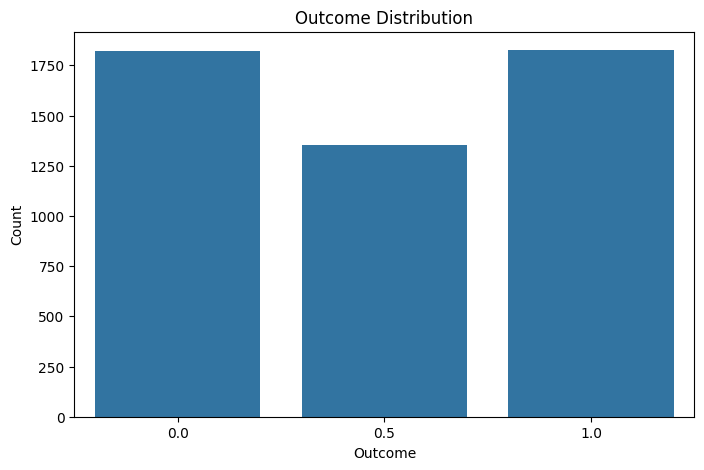

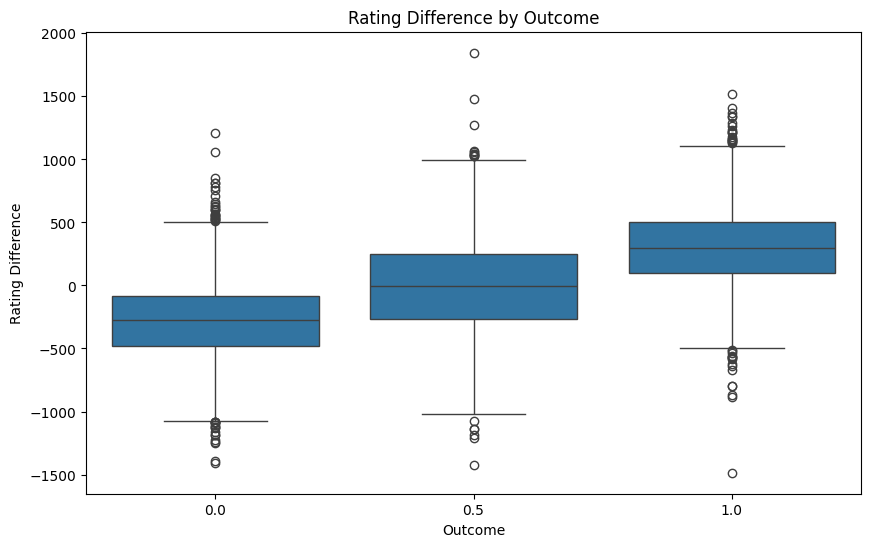

In [8]:
plt.figure(figsize=(8,5))
outcome_counts = data['outcome'].value_counts().sort_index()
sns.barplot(x=outcome_counts.index, y=outcome_counts.values)
plt.title('Outcome Distribution')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='outcome', y='rating_diff', data=data)
plt.title('Rating Difference by Outcome')
plt.xlabel('Outcome')
plt.ylabel('Rating Difference')
plt.show()

Converting categorical variables to dummy variables

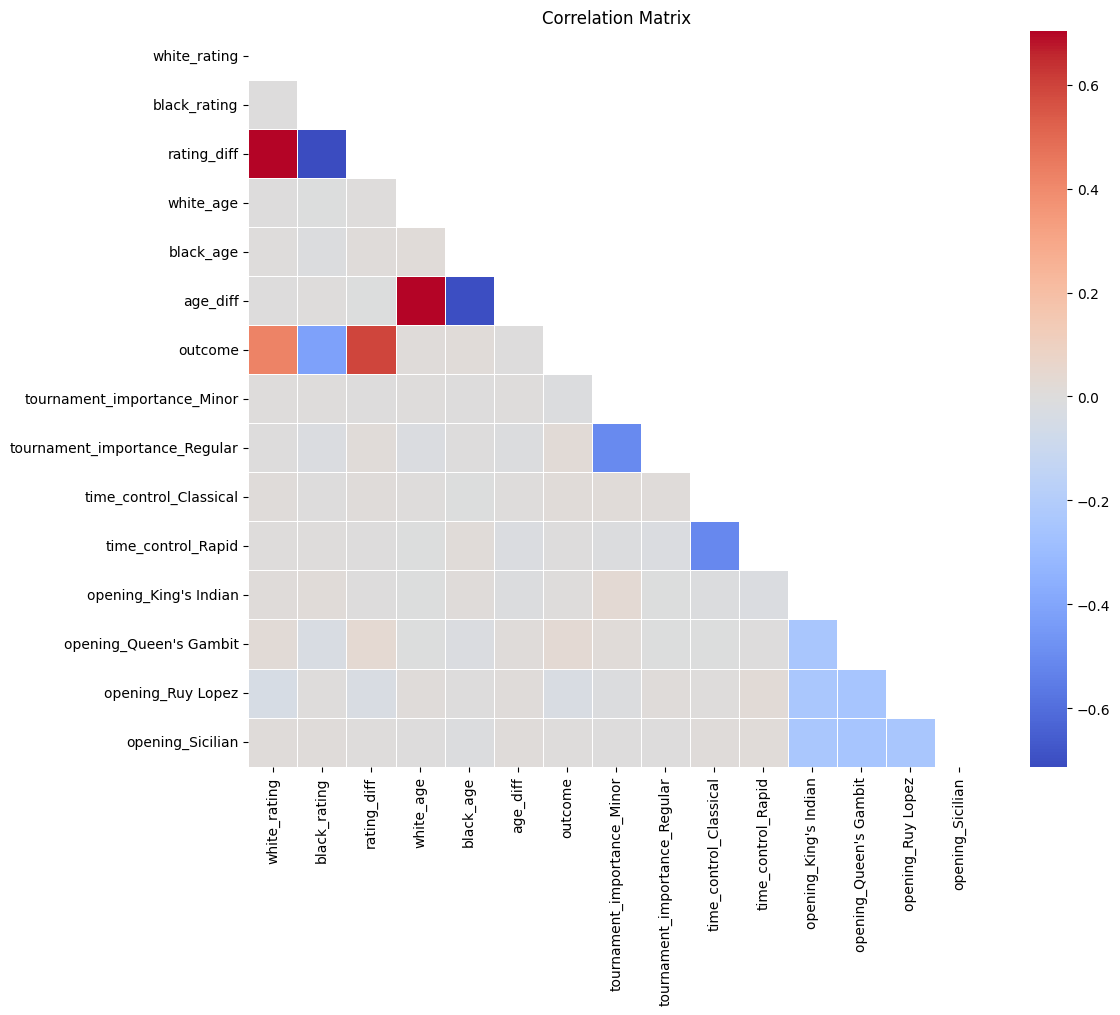

In [9]:
data_encoded = pd.get_dummies(data, columns=['tournament_importance', 'time_control', 'opening'], drop_first=True)

plt.figure(figsize=(12,10))
corr_matrix = data_encoded.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=False, fmt=".2f", square=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

Outcome by tournament importance

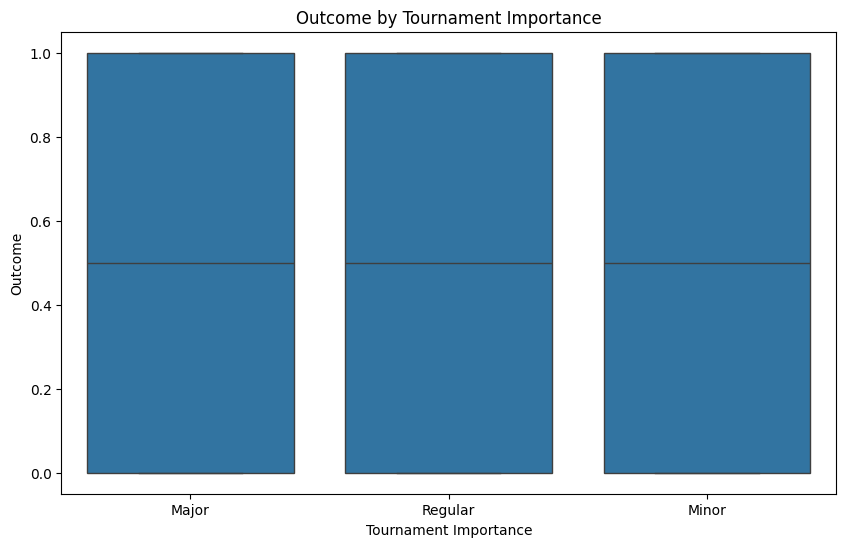

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='tournament_importance', y='outcome', data=data)
plt.title('Outcome by Tournament Importance')
plt.xlabel('Tournament Importance')
plt.ylabel('Outcome')
plt.show()

outcome by time control

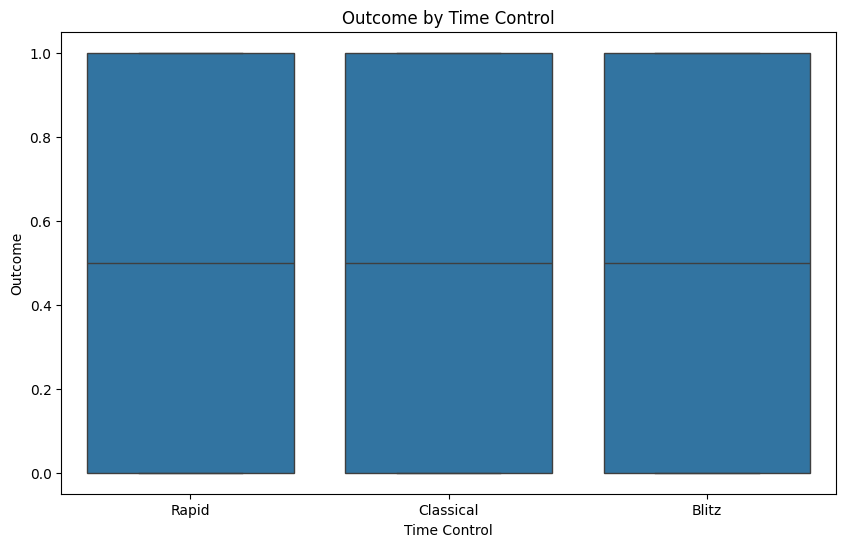

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='time_control', y='outcome', data=data)
plt.title('Outcome by Time Control')
plt.xlabel('Time Control')
plt.ylabel('Outcome')
plt.show()

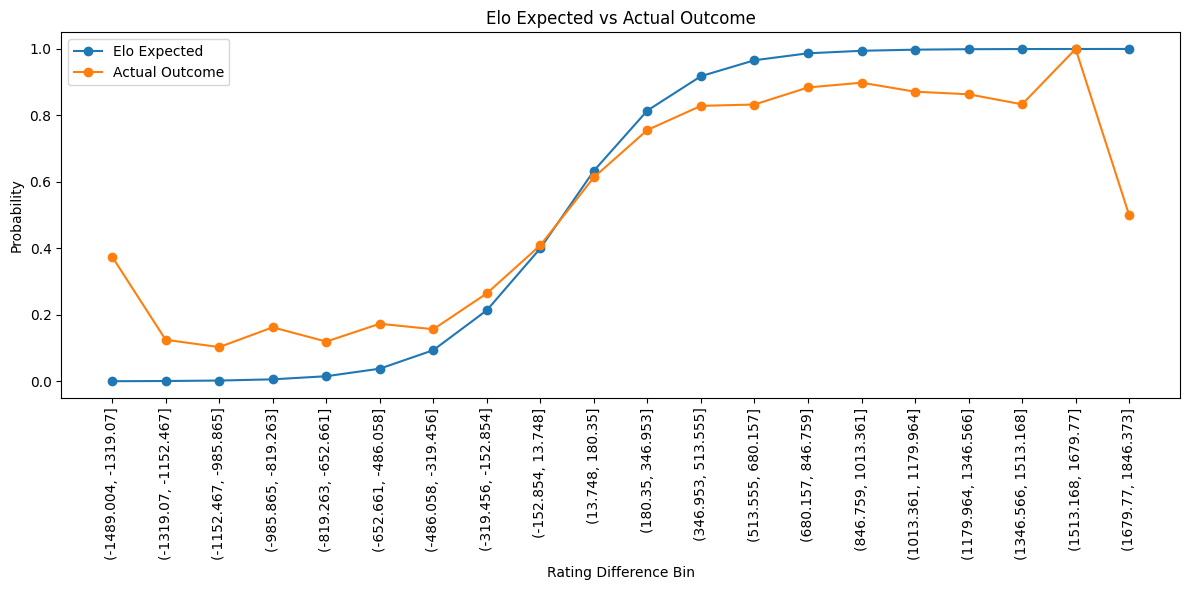

In [12]:
data['elo_expected'] = expected_score(data['rating_diff'])
data['actual_outcome_numeric'] = data['outcome']


data['rating_diff_bin'] = pd.cut(data['rating_diff'], bins = 20)
grouped = data.groupby('rating_diff_bin').agg({'elo_expected': 'mean', 'actual_outcome_numeric': 'mean'}).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(range(len(grouped)),grouped['elo_expected'],'o-', label='Elo Expected')
plt.plot(range(len(grouped)), grouped['actual_outcome_numeric'],'o-', label='Actual Outcome')
plt.xticks(range(len(grouped)), [str(x) for x in grouped['rating_diff_bin']], rotation=90)

plt.title('Elo Expected vs Actual Outcome')
plt.xlabel('Rating Difference Bin')
plt.ylabel('Probability')
plt.legend()
plt.tight_layout()
plt.show()

feature engineering

In [13]:
data['rating_ratio'] = data['white_rating'] / data['black_rating']
data['experience_factor'] = data['white_age'] * data['white_rating'] / (data['black_age'] * data['black_rating'])
data['log_rating_diff'] = np.log1p(np.abs(data['rating_diff'])) * np.sign(data['rating_diff'])

data['is_classical'] = (data['time_control'] == 'Classical').astype(int)
data['is_major'] = (data['tournament_importance'] == 'Major').astype(int)

data['tournament_rating_impact'] = 0
major_mask = data['tournament_importance'] == 'Major'
minor_mask = data['tournament_importance'] == 'Minor'
data.loc[major_mask, 'tournament_rating_impact'] = data.loc[major_mask, 'rating_diff'] * 1.2
data.loc[minor_mask, 'tournament_rating_impact'] = data.loc[minor_mask, 'rating_diff'] * 0.8
data['time_control_weight'] = 1.0
data.loc[data['time_control'] == 'Blitz', 'time_control_weight'] = 0.7
data.loc[data['time_control'] == 'Classical', 'time_control_weight'] = 1.3


data['rating_diff_squared'] = data['rating_diff'] ** 2 * np.sign(data['rating_diff'])

opening_advantage = {
    'Sicilian': 0.02, 
    'French': -0.01, 
    'Ruy Lopez': 0.01, 
    'Queen\'s Gambit': 0.0, 
    'King\'s Indian': -0.02
}
data['opening_advantage'] = data['opening'].map(opening_advantage)

print(data[['rating_diff', 'rating_ratio', 'experience_factor', 'log_rating_diff', 
           'is_classical', 'is_major', 'tournament_rating_impact', 
           'time_control_weight', 'rating_diff_squared', 'opening_advantage']].head())

   rating_diff  rating_ratio  experience_factor  log_rating_diff  \
0   276.142151      1.201142           0.969393         5.624531   
1    94.544942      1.069316           0.968152         4.559597   
2   732.999513      1.762503           1.371285         6.598508   
3   555.936014      1.396821           1.094413         6.322450   
4  -290.094737      0.831325           1.576411        -5.673649   

   is_classical  is_major  tournament_rating_impact  time_control_weight  \
0             0         1                331.370581                  1.0   
1             1         0                  0.000000                  1.3   
2             1         1                879.599416                  1.3   
3             1         0                444.748812                  1.3   
4             0         0               -232.075790                  1.0   

   rating_diff_squared  opening_advantage  
0         76254.487288               0.00  
1          8938.746089              -0.01  
2 

In [14]:
data_encoded = pd.get_dummies(data, columns=['tournament_importance', 'time_control', 'opening'], drop_first=True)
feature_cols = [col for col in data_encoded.columns if col != 'outcome' and col != 'actual_outcome_numeric' 
                and col != 'elo_expected' and col != 'rating_diff_bin']
X = data_encoded[feature_cols]
y = data_encoded['outcome']

In [15]:
scaler = StandardScaler()
numerical_cols = ['white_rating', 'black_rating', 'rating_diff', 'white_age', 'black_age', 
                  'age_diff', 'rating_ratio', 'experience_factor', 'log_rating_diff', 
                  'tournament_rating_impact', 'rating_diff_squared']
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

/tmp/ipykernel_11295/2123040704.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_cols] = scaler.fit_transform(X[numerical_cols])


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Feature columns:", feature_cols)

print("\nMissing values in training set:")
print(X_train.isnull().sum().sum())

Training set shape: (4000, 23)
Testing set shape: (1000, 23)
Feature columns: ['white_rating', 'black_rating', 'rating_diff', 'white_age', 'black_age', 'age_diff', 'rating_ratio', 'experience_factor', 'log_rating_diff', 'is_classical', 'is_major', 'tournament_rating_impact', 'time_control_weight', 'rating_diff_squared', 'opening_advantage', 'tournament_importance_Minor', 'tournament_importance_Regular', 'time_control_Classical', 'time_control_Rapid', "opening_King's Indian", "opening_Queen's Gambit", 'opening_Ruy Lopez', 'opening_Sicilian']

Missing values in training set:
0


#### Model Building - Linear Regression

In [17]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_lr)
r2 = r2_score(y_test, y_pred_lr)

print("Linear Regression Results:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-Squared: {r2:.4f}")

Linear Regression Results:
Mean Squared Error: 0.1114
R-Squared: 0.3886


Feature importance


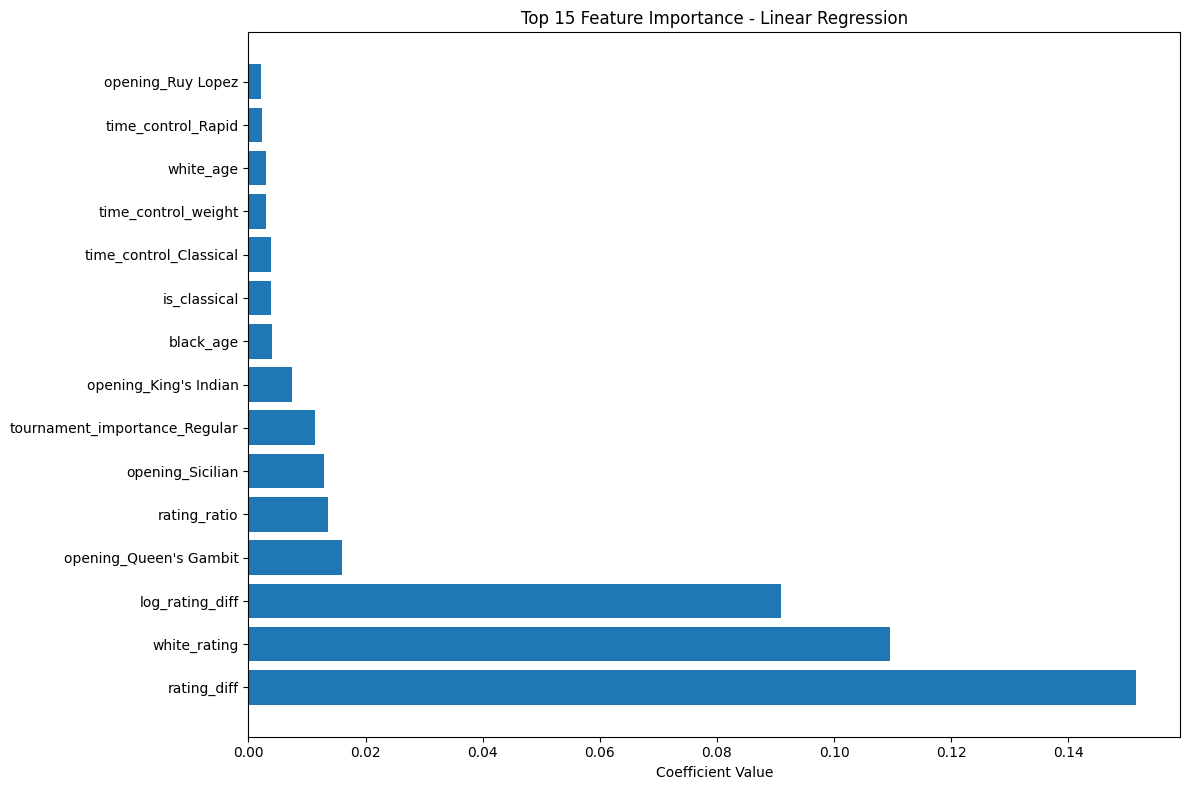

In [18]:
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_
})
coef_df = coef_df.sort_values('Coefficient', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(coef_df['Feature'][:15], coef_df['Coefficient'][:15])
plt.title('Top 15 Feature Importance - Linear Regression')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

#### Model building - Random Forest Regression

In [19]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regression Results:")
print(f"Mean Squared Error: {mse_rf:.4f}")
print(f"R-Squared: {r2_rf:.4f}")

Random Forest Regression Results:
Mean Squared Error: 0.1167
R-Squared: 0.3594


Feature importance

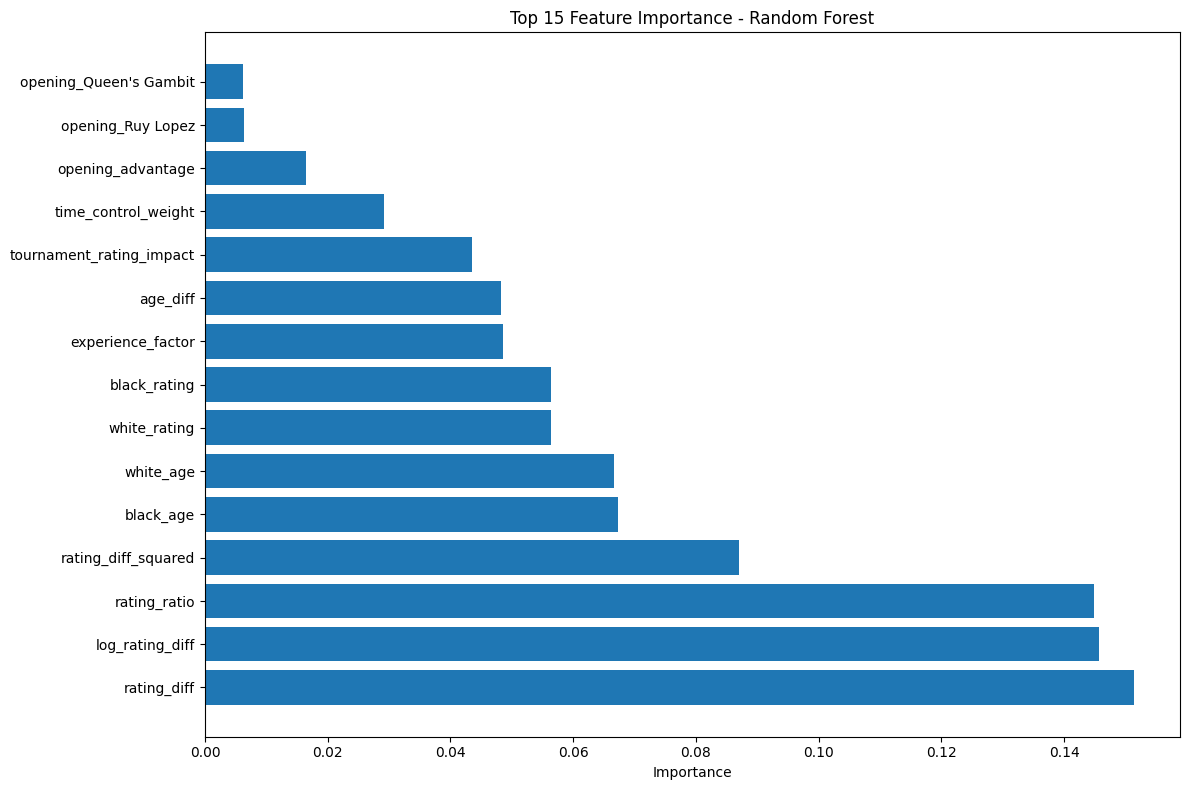

In [20]:
feature_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
})
feature_imp = feature_imp.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_imp['Feature'][:15], feature_imp['Importance'][:15])
plt.title('Top 15 Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [21]:
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Regression Results:")
print(f"Mean Squared Error: {mse_xgb:.4f}")
print(f"R-Squared: {r2_xgb:.4f}")

XGBoost Regression Results:
Mean Squared Error: 0.1144
R-Squared: 0.3719


Feature Importance

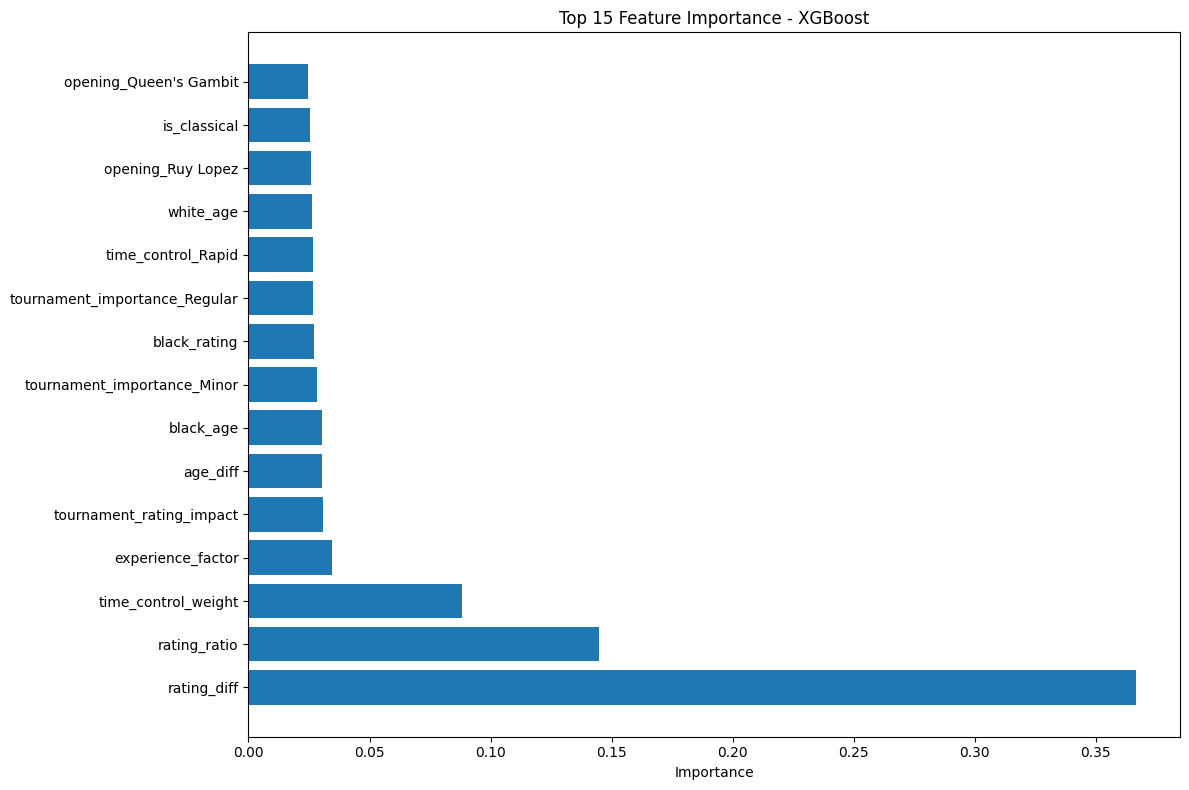

In [22]:
xgb_feature_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
})
xgb_feature_imp = xgb_feature_imp.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(xgb_feature_imp['Feature'][:15], xgb_feature_imp['Importance'][:15])
plt.title('Top 15 Feature Importance - XGBoost')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

#### Comparing the Models

In [23]:
results = pd.DataFrame({
    'Actual': y_test,
    'Linear Regression': y_pred_lr,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'Elo Expected': data_encoded.loc[y_test.index, 'elo_expected']
})
for model in ['Linear Regression', 'Random Forest', 'XGBoost']:
    results[model] = np.clip(results[model], 0, 1)

models = ['Linear Regression', 'Random Forest', 'XGBoost', 'Elo Expected']
mse_scores = [mean_squared_error(results['Actual'], results[model]) for model in models]
r2_scores = [r2_score(results['Actual'], results[model]) for model in models]


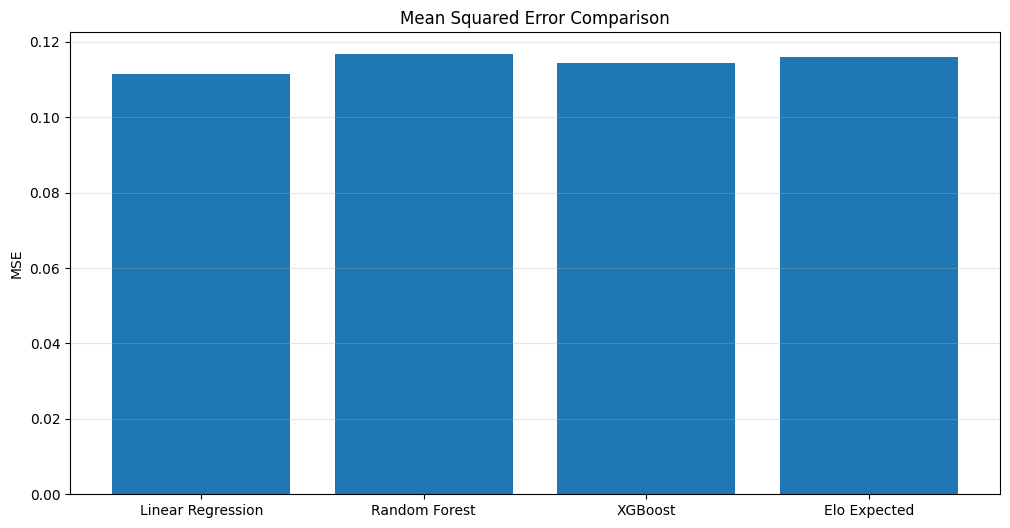

In [24]:
# MSE comparison
plt.figure(figsize=(12, 6))
plt.bar(models, mse_scores)
plt.title('Mean Squared Error Comparison')
plt.ylabel('MSE')
plt.grid(axis='y', alpha=0.3)
plt.show()

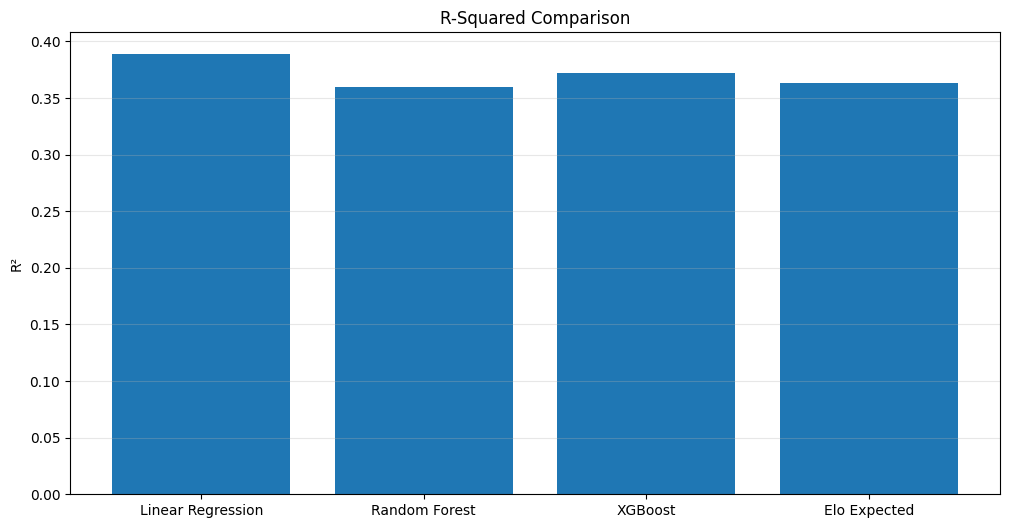

In [25]:
# R² comparison
plt.figure(figsize=(12, 6))
plt.bar(models, r2_scores)
plt.title('R-Squared Comparison')
plt.ylabel('R²')
plt.grid(axis='y', alpha=0.3)
plt.show()

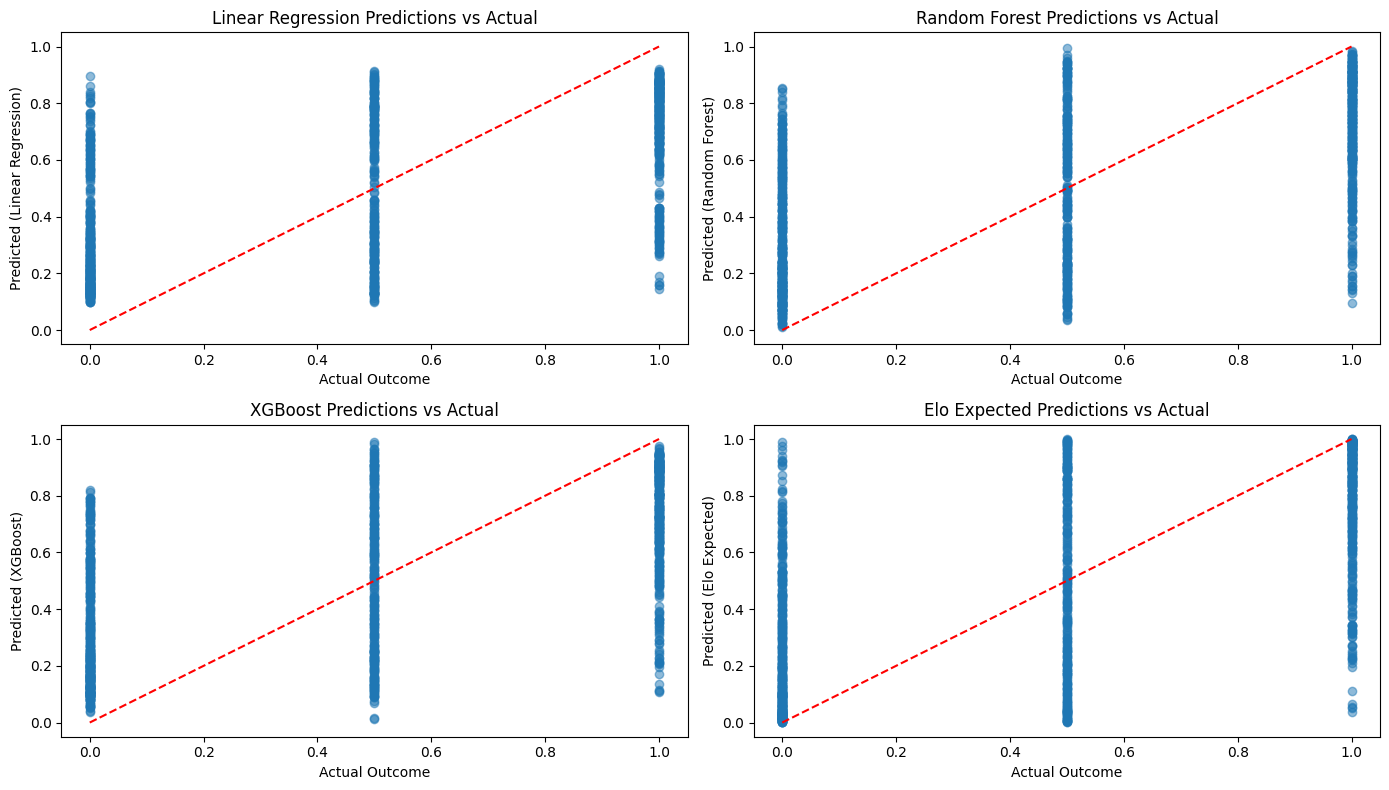

In [26]:
# pred vs actual
plt.figure(figsize=(14, 8))
for i, model in enumerate(models):
    plt.subplot(2, 2, i+1)
    plt.scatter(results['Actual'], results[model], alpha=0.5)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('Actual Outcome')
    plt.ylabel(f'Predicted ({model})')
    plt.title(f'{model} Predictions vs Actual')
plt.tight_layout()
plt.show()

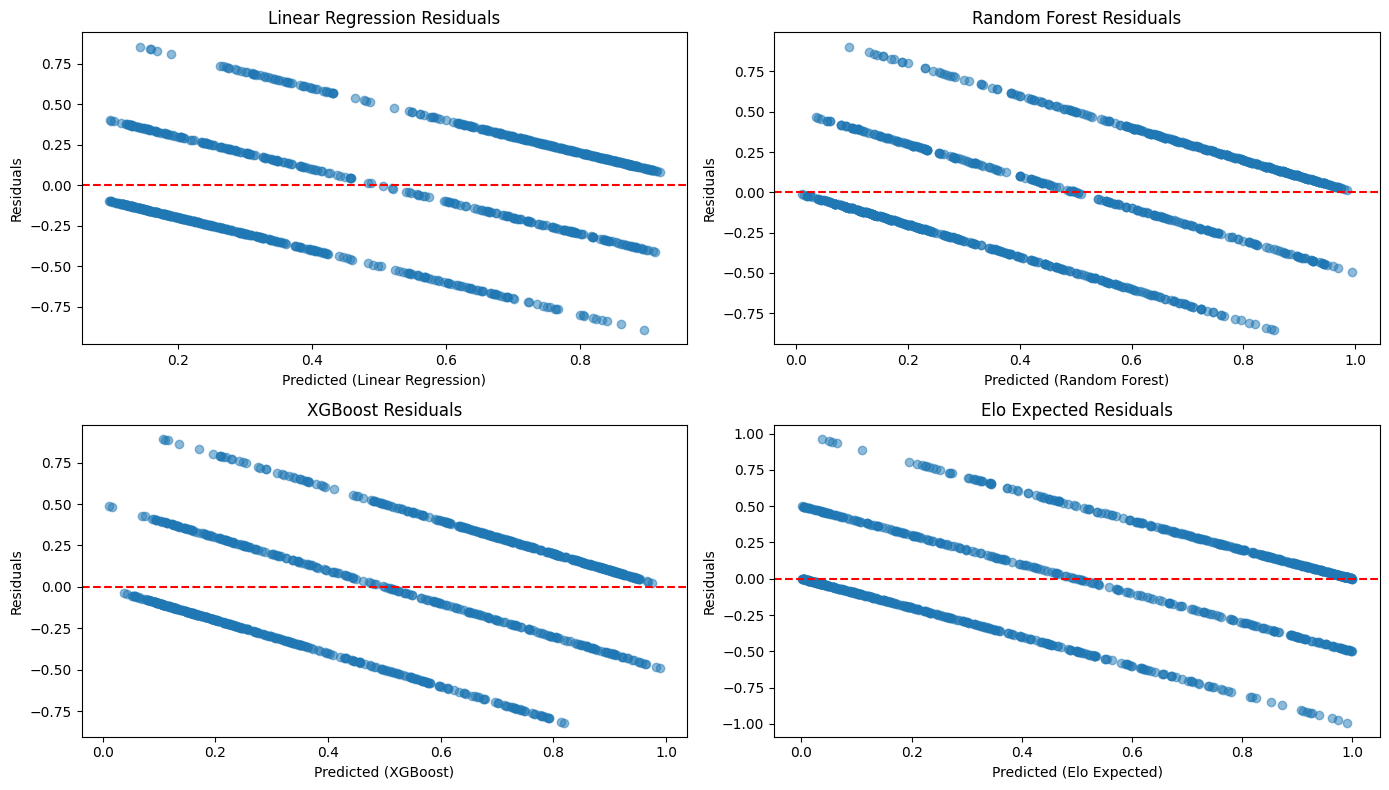

In [27]:
# residual analysis
plt.figure(figsize=(14, 8))
for i, model in enumerate(models):
    plt.subplot(2, 2, i+1)
    residuals = results['Actual'] - results[model]
    plt.scatter(results[model], residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel(f'Predicted ({model})')
    plt.ylabel('Residuals')
    plt.title(f'{model} Residuals')
plt.tight_layout()
plt.show()

#### Hyperparameter Tuning

In [28]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)

best_xgb = grid_search.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)
mse_best_xgb = mean_squared_error(y_test, y_pred_best_xgb)
r2_best_xgb = r2_score(y_test, y_pred_best_xgb)

print("Tuned XGBoost Results:")
print(f"Mean Squared Error: {mse_best_xgb:.4f}")
print(f"R-Squared: {r2_best_xgb:.4f}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Best score: 0.10562915995291382
Tuned XGBoost Results:
Mean Squared Error: 0.1116
R-Squared: 0.3874


Model Interpretation

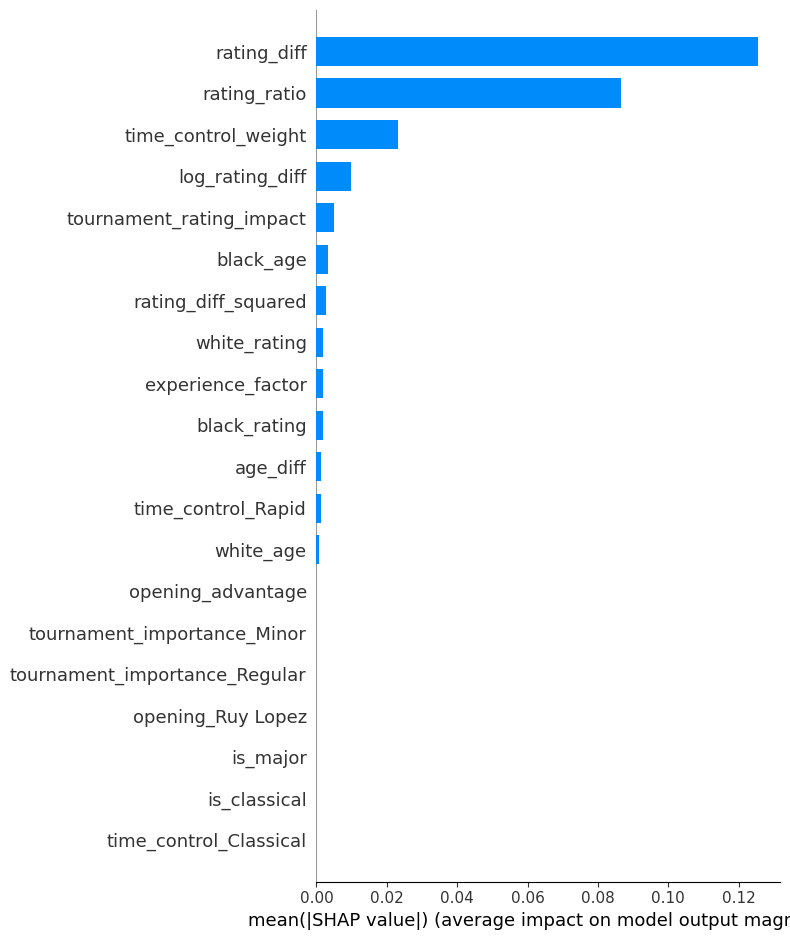

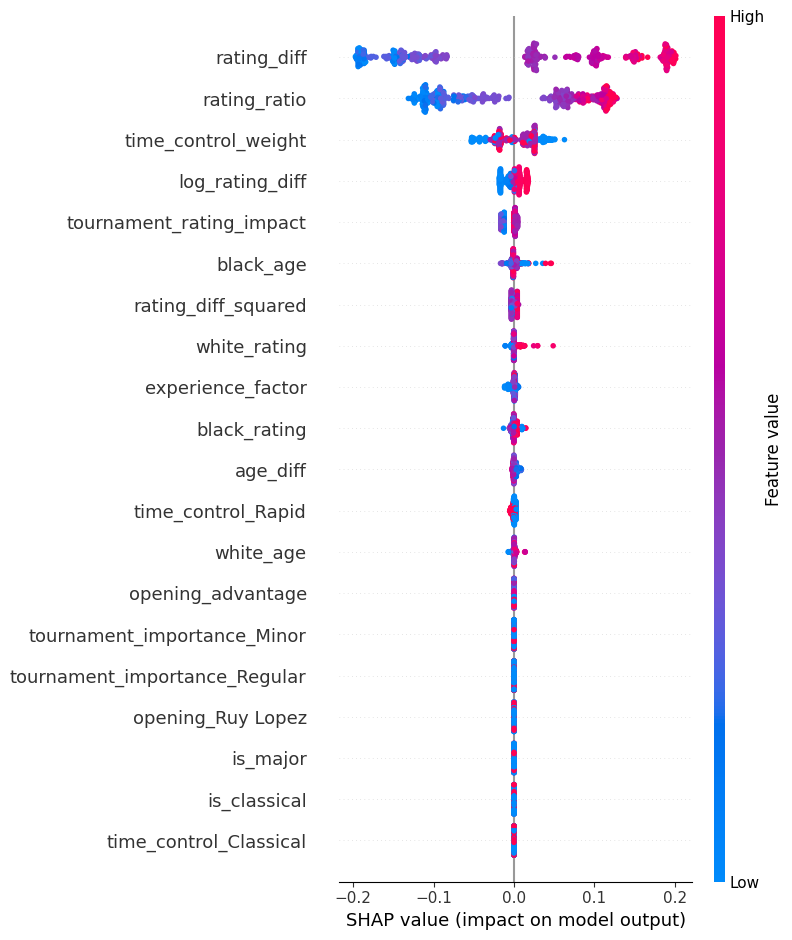

<Figure size 1000x600 with 0 Axes>

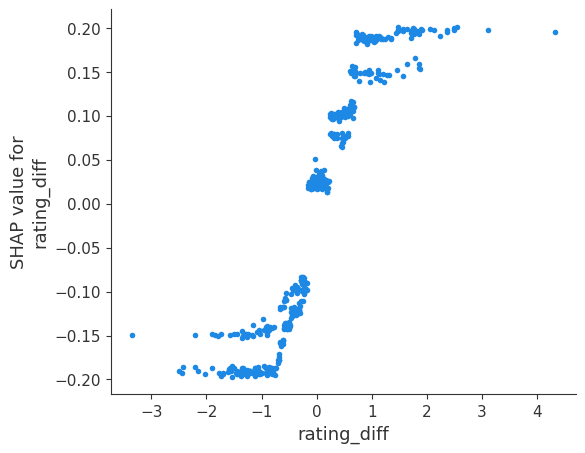

<Figure size 1000x600 with 0 Axes>

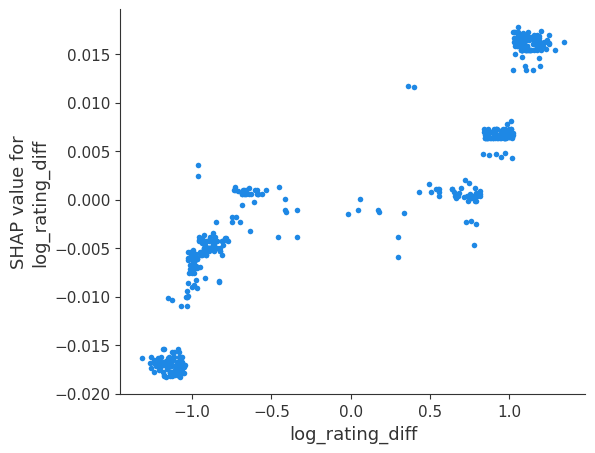

<Figure size 1000x600 with 0 Axes>

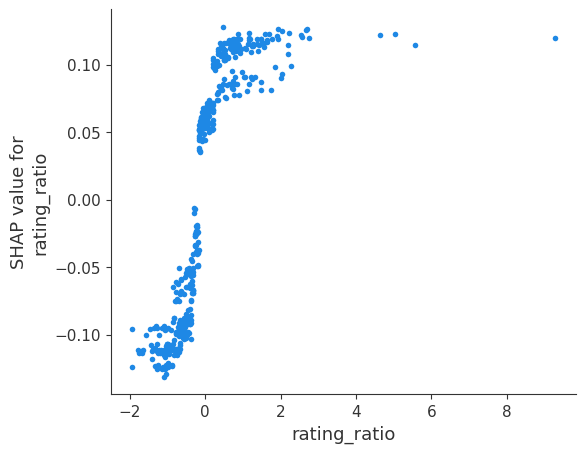

In [33]:
sample_size = min(500, len(X_test))
sample_indices = np.random.choice(X_test.index, sample_size, replace = False)
X_test_sample = X_test.loc[sample_indices]

explainer = shap.Explainer(best_xgb)
shap_values = explainer.shap_values(X_test_sample)

plt.figure(figsize=(12,10))
shap.summary_plot(shap_values, X_test_sample, plot_type='bar')
plt.show()

plt.figure(figsize=(12,10))
shap.summary_plot(shap_values, X_test_sample)
plt.show()

top_features = feature_imp['Feature'][:3].values
for feature in top_features:
    plt.figure(figsize=(10,6))
    shap.dependence_plot(feature, shap_values, X_test_sample, interaction_index=None)
    plt.show()

In [34]:
def predict_chess_outcome(white_rating, black_rating, white_age, black_age, 
                         tournament_importance, time_control, opening):
    input_data = pd.DataFrame({
        'white_rating': [white_rating],
        'black_rating': [black_rating],
        'rating_diff': [white_rating - black_rating],
        'white_age': [white_age],
        'black_age': [black_age],
        'age_diff': [white_age - black_age],
        'tournament_importance': [tournament_importance],
        'time_control': [time_control],
        'opening': [opening]
    })
    input_data['rating_ratio'] = input_data['white_rating'] / input_data['black_rating']
    input_data['experience_factor'] = input_data['white_age'] * input_data['white_rating'] / (input_data['black_age'] * input_data['black_rating'])
    input_data['log_rating_diff'] = np.log1p(np.abs(input_data['rating_diff'])) * np.sign(input_data['rating_diff'])
    input_data['is_classical'] = (input_data['time_control'] == 'Classical').astype(int)
    input_data['is_major'] = (input_data['tournament_importance'] == 'Major').astype(int)

    input_data['tournament_rating_impact'] = 0
    if tournament_importance == 'Major':
        input_data['tournament_rating_impact'] = input_data['rating_diff'] * 1.2
    elif tournament_importance == 'Minor':
        input_data['tournament_rating_impact'] = input_data['rating_diff'] * 0.8

    input_data['time_control_weight'] = 1.0
    if time_control == 'Blitz':
        input_data['time_control_weight'] = 0.7
    elif time_control == 'Classical':
        input_data['time_control_weight'] = 1.3
    
    input_data['rating_diff_squared'] = input_data['rating_diff'] ** 2 * np.sign(input_data['rating_diff'])
    
    opening_advantage = {
        'Sicilian': 0.02, 
        'French': -0.01, 
        'Ruy Lopez': 0.01, 
        'Queen\'s Gambit': 0.0, 
        'King\'s Indian': -0.02
    }
    input_data['opening_advantage'] = input_data['opening'].map(opening_advantage)
    
    input_encoded = pd.get_dummies(input_data, columns=['tournament_importance', 'time_control', 'opening'], drop_first=True)
    
    for col in X.columns:
        if col not in input_encoded.columns:
            input_encoded[col] = 0
    
    input_final = input_encoded[X.columns]
    input_final[numerical_cols] = scaler.transform(input_final[numerical_cols])    
    predicted_outcome = best_xgb.predict(input_final)[0]
    predicted_outcome = np.clip(predicted_outcome, 0, 1)
    
    # Converting to win/draw/loss probabilities
    # Here we're making assumptions about the distribution of draw probabilities
    if predicted_outcome < 0.25:
        black_win_prob = 1 - predicted_outcome - 0.1
        draw_prob = 0.1 + predicted_outcome
        white_win_prob = predicted_outcome
    elif predicted_outcome > 0.75:
        white_win_prob = predicted_outcome
        draw_prob = 0.1 + (1 - predicted_outcome)
        black_win_prob = 1 - predicted_outcome - 0.1
    else:
        draw_center = 0.5
        draw_prob = 0.4 - 0.8 * abs(predicted_outcome - draw_center)
        if predicted_outcome < 0.5:
            black_win_prob = 1 - predicted_outcome - draw_prob
            white_win_prob = predicted_outcome
        else:
            white_win_prob = predicted_outcome
            black_win_prob = 1 - predicted_outcome - draw_prob
    
    elo_expected = expected_score(white_rating - black_rating)
    
    return {
        'Model Prediction': predicted_outcome,
        'White Win Probability': white_win_prob,
        'Draw Probability': draw_prob,
        'Black Win Probability': black_win_prob,
        'Elo Expected Score': elo_expected
    }

In [35]:
# Testing the prediction function
example_prediction = predict_chess_outcome(
    white_rating=2650, 
    black_rating=2500, 
    white_age=35, 
    black_age=28, 
    tournament_importance='Major', 
    time_control='Classical',
    opening='Sicilian'
)

print("Prediction for a 2650-rated player against a 2500-rated player:")
for outcome, probability in example_prediction.items():
    print(f"{outcome}: {probability:.4f}")

Prediction for a 2650-rated player against a 2500-rated player:
Model Prediction: 0.7290
White Win Probability: 0.7290
Draw Probability: 0.2168
Black Win Probability: 0.0542
Elo Expected Score: 0.7034


Let's create a tournament planning for 8 players

Most Competitive Matchups:
       White     Black  White Rating  Black Rating  White Win Prob  Draw Prob  \
14  Player C  Player E          2650          2580        0.587133   0.330294   
8   Player B  Player D          2680          2600        0.587133   0.330294   
23  Player E  Player G          2580          2510        0.596018   0.323186   
22  Player E  Player F          2580          2540        0.601377   0.318898   
19  Player D  Player F          2600          2540        0.601377   0.318898   

    Black Win Prob  Expected Excitement  
14        0.082573             0.495440  
8         0.082573             0.495440  
23        0.080796             0.484778  
22        0.079725             0.478347  
19        0.079725             0.478347  


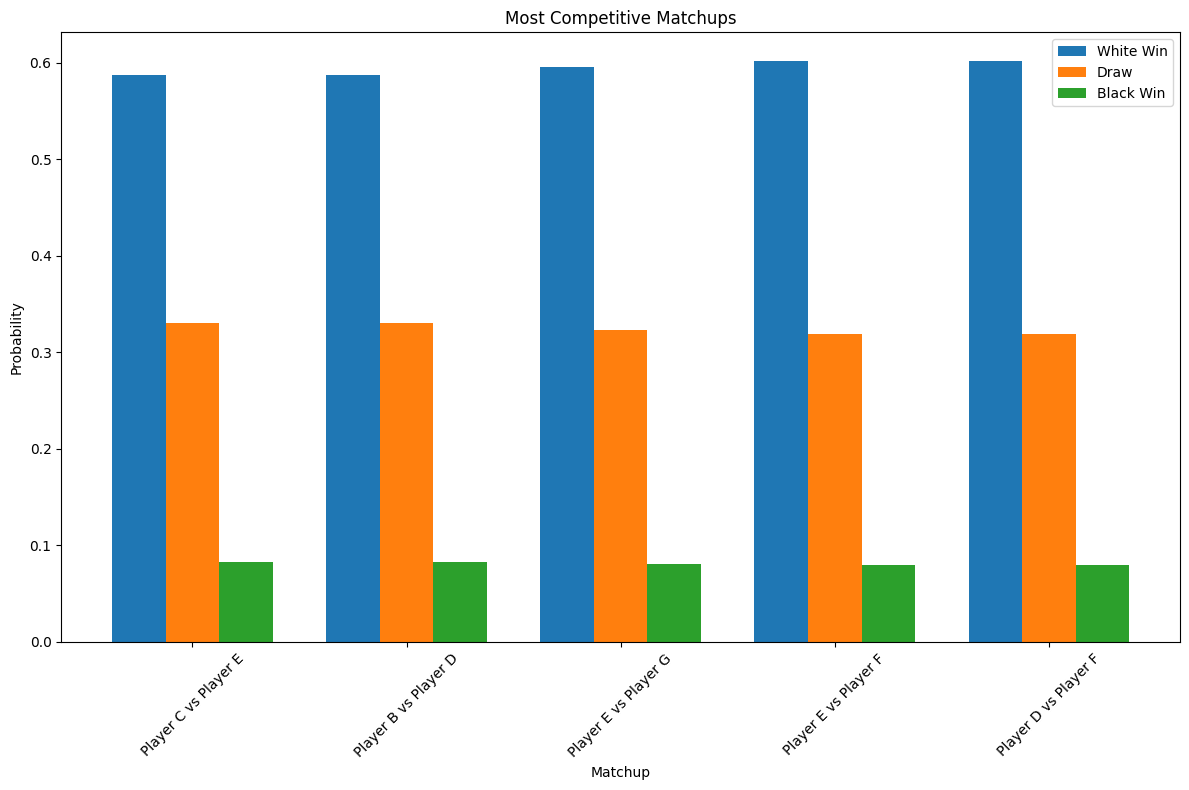

In [36]:
players = pd.DataFrame({
    'Name': ['Player A', 'Player B', 'Player C', 'Player D', 
             'Player E', 'Player F', 'Player G', 'Player H'],
    'Rating': [2720, 2680, 2650, 2600, 2580, 2540, 2510, 2480],
    'Age': [28, 35, 42, 22, 25, 31, 44, 19]
})
pairings = []
for i in range(len(players)):
    for j in range(i+1, len(players)):
        pairings.append((i, j))
results = []
for white_idx, black_idx in pairings:
    white_player = players.iloc[white_idx]
    black_player = players.iloc[black_idx]
    
    prediction = predict_chess_outcome(
        white_rating=white_player['Rating'],
        black_rating=black_player['Rating'],
        white_age=white_player['Age'],
        black_age=black_player['Age'],
        tournament_importance='Major',
        time_control='Classical',
        opening='Queen\'s Gambit'  
    )
    
    results.append({
        'White': white_player['Name'],
        'Black': black_player['Name'],
        'White Rating': white_player['Rating'],
        'Black Rating': black_player['Rating'],
        'Rating Diff': white_player['Rating'] - black_player['Rating'],
        'White Win Prob': prediction['White Win Probability'],
        'Draw Prob': prediction['Draw Probability'],
        'Black Win Prob': prediction['Black Win Probability'],
        'Expected Excitement': 1 - abs(prediction['White Win Probability'] - prediction['Black Win Probability']),
    })

tournament_df = pd.DataFrame(results)
competitive_matchups = tournament_df.sort_values('Expected Excitement', ascending=False)

print("Most Competitive Matchups:")
print(competitive_matchups[['White', 'Black', 'White Rating', 'Black Rating', 
                           'White Win Prob', 'Draw Prob', 'Black Win Prob', 
                           'Expected Excitement']].head())
plt.figure(figsize=(12, 8))
top_matchups = competitive_matchups.head(5)
x = np.arange(len(top_matchups))
width = 0.25

plt.bar(x - width, top_matchups['White Win Prob'], width, label='White Win')
plt.bar(x, top_matchups['Draw Prob'], width, label='Draw')
plt.bar(x + width, top_matchups['Black Win Prob'], width, label='Black Win')

plt.xlabel('Matchup')
plt.ylabel('Probability')
plt.title('Most Competitive Matchups')
plt.xticks(x, [f"{row['White']} vs {row['Black']}" for _, row in top_matchups.iterrows()], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()